In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import pandas as pd
import itertools
import joblib
import gc

import sys
from pathlib import Path
functions_path = Path("/home/mokr/Loss_Functions_Paper/ML_Functions/")
sys.path.append(str(functions_path))

import ML_functions
from ML_functions import HydroDataset

import torch
import torch.nn as nn
from collections import defaultdict
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from ML_Plots import CMAL_quantile, transform_CMAL_parameters, draw_from_CMAL_distribution, draw_from_CMAL_distribution_np, load_and_unnormalize, get_ensemble_members_vectorized, plot_ensemble_predictions, plot_dispersion_histograms, load_and_unnormalize

from ML_Losses import compute_log_likelihood, compute_CDF, crps_loss, compute_crps, calculate_overall_crps, get_member_summaries_torch , compute_nse, compute_kge

from ML_functions import transform_CMAL_parameters_multi, run_ensemble_predictions

# Downloading data and models

- Making a general validation dataloader
- Making seperate dataloaders for each of the three focus basins
    - hysets_11477000 catchment in California	
    - hysets_12324400 medium catchment in Montana
    - hysets_01358000 Hudson river New York

In [7]:
Conditional_Model =  torch.load('/home/mokr/Loss_Functions_Paper/Models/Conditional/hyperparameter_test/Conditional_lr_0.001_bi_False_h_256_256_256_0506_30Epochs.pth', map_location=torch.device('cpu')) # BEST CRPS Model, 46
Probabilistic_Model = torch.load('/home/mokr/Loss_Functions_Paper/Models/Probabilistic/hyperparameter_test/Probabilistic_lr_0.001_bi_False_h_128_128_64_0503_30Epochs.pth', map_location=torch.device('cpu')) # Best Probabilistic models so far

Fixed_Noise_Seeded_Model = torch.load('/home/mokr/Loss_Functions_Paper/Models/Seeded/hyperparameter_test/Seeded_lr_0.001_bi_False_h_256_256_128_0623_8_0.9_5_True_Epochs.pth', weights_only = False, map_location=torch.device('cpu')) # Best Seeded Model so far
Non_Fixed_Noise_Seeded_Model = torch.load('/home/mokr/Loss_Functions_Paper/Models/Seeded/hyperparameter_test/Seeded_lr_0.001_bi_False_h_128_128_64_0526_8_0.85_5_False_Epochs.pth', weights_only = False, map_location=torch.device('cpu')) # 0.06 val loss

NLL_Conditional_Model = Conditional_Model

/etc/ecmwf/ssd/ssd1/jupyterhub/mokr-jupyterhub/tmpdirs/mokr.40771318/ipykernel_2394893/282249482.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  Conditional_Model =  tor

In [8]:
loaded_validation_data = torch.load("/perm/mokr/10Day_Loss_Function_Validation_Dataset_Binary_P0.pt")
Validation_Dataloader = DataLoader(loaded_validation_data, batch_size= 1, shuffle=True, pin_memory=True)

target_ids = ['hysets_11477000', 'hysets_12324400', 'hysets_01358000']


# Create a dictionary to hold lists for each target ID
filtered_data = {station_id: [] for station_id in target_ids}

# Loop through your data and distribute accordingly
for entry in loaded_validation_data:
    key = entry[4]
    if key in filtered_data:
        filtered_data[key].append(entry)

# Unpack to individual variables (optional)
hysets_11477000_data = filtered_data['hysets_11477000']
hysets_12324400_data = filtered_data['hysets_12324400']
hysets_01358000_data = filtered_data['hysets_01358000']


Hysets_11477000_Dataloader = DataLoader(hysets_11477000_data, batch_size= 1, shuffle=False, pin_memory=True)
Hysets_12324400_Dataloader = DataLoader(hysets_12324400_data, batch_size= 1, shuffle=False, pin_memory=True)
Hysets_01358000_Dataloader = DataLoader(hysets_01358000_data, batch_size= 1, shuffle=False, pin_memory=True)


/etc/ecmwf/ssd/ssd1/jupyterhub/mokr-jupyterhub/tmpdirs/mokr.40771318/ipykernel_2394893/1061681446.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_validation_data 

In [9]:
loaded_validation_data = torch.load("/perm/mokr/10Day_Loss_Function_Validation_Dataset_Binary_P1.pt")

/etc/ecmwf/ssd/ssd1/jupyterhub/mokr-jupyterhub/tmpdirs/mokr.40771318/ipykernel_2394893/858835745.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_validation_data =

In [10]:
Validation_Dataloader = DataLoader(loaded_validation_data, batch_size= 1, shuffle=True, pin_memory=True)

len(Validation_Dataloader)

349650

In [11]:
scaler_path='/home/mokr/Loss_Functions_Paper/Scalers/discharge_caravan_scalers.joblib'

# Running models and storing results

- Hydrograph results for each of the locations and models
- Per day CRPS scores
- Overall CRPS scores

In [27]:
import importlib
sys.path.append(str(functions_path))
importlib.reload(ML_Losses)
from ML_Losses import get_member_summaries_torch, compute_kge
import ML_Plots
importlib.reload(ML_Plots)

from ML_Plots import get_nonbinary_ensemble_members, process_ensemble_predictions, variogram_score_torch, variogram_score


In [22]:
Validation_Dataloader = DataLoader(loaded_validation_data, batch_size= 1, shuffle=True, pin_memory=True)
Hysets_01358000_Dataloader = DataLoader(hysets_01358000_data, batch_size= 1, shuffle=False, pin_memory=True)
Hysets_11477000_Dataloader = DataLoader(hysets_11477000_data, batch_size= 1, shuffle=False, pin_memory=True)
Hysets_12324400_Dataloader = DataLoader(hysets_12324400_data, batch_size= 1, shuffle=False, pin_memory=True)

In [23]:
ensemble_summaries = {
    "CRPS": [],
    "NLL": [],
    "Fixed_Seeded": [],
    "Non_Fixed_Seeded": [],
    "Probabilistic": [],
    "Discharge": []
}


variogram_scores = {    
    "CRPS": [],
    "NLL": [],
    "Fixed_Seeded": [],
    "Non_Fixed_Seeded": [],
    "Probabilistic": []
}


crps_per_leadtime = {
    "CRPS": [],
    "NLL": [],
    "Fixed_Seeded": [],
    "Non_Fixed_Seeded": [],
    "Probabilistic": []
}

stored_forecasts = {
    "CRPS": [],
    "NLL": [],
    "Fixed_Seeded": [],
    "Non_Fixed_Seeded": [],
    "Probabilistic": [],
    "Discharge": []
}

KGE_scores = {
    "CRPS": [],
    "NLL": [],
    "Fixed_Seeded": [],
    "Non_Fixed_Seeded": [],
    "Probabilistic": []
}

NSE_scores = {
    "CRPS": [],
    "NLL": [],
    "Fixed_Seeded": [],
    "Non_Fixed_Seeded": [],
    "Probabilistic": []
}


# Store forecasts by basin and model
basin_forecasts = {}

dates = []
basins = []

0
hysets_10316500 2016-06-13 00:00:00 12


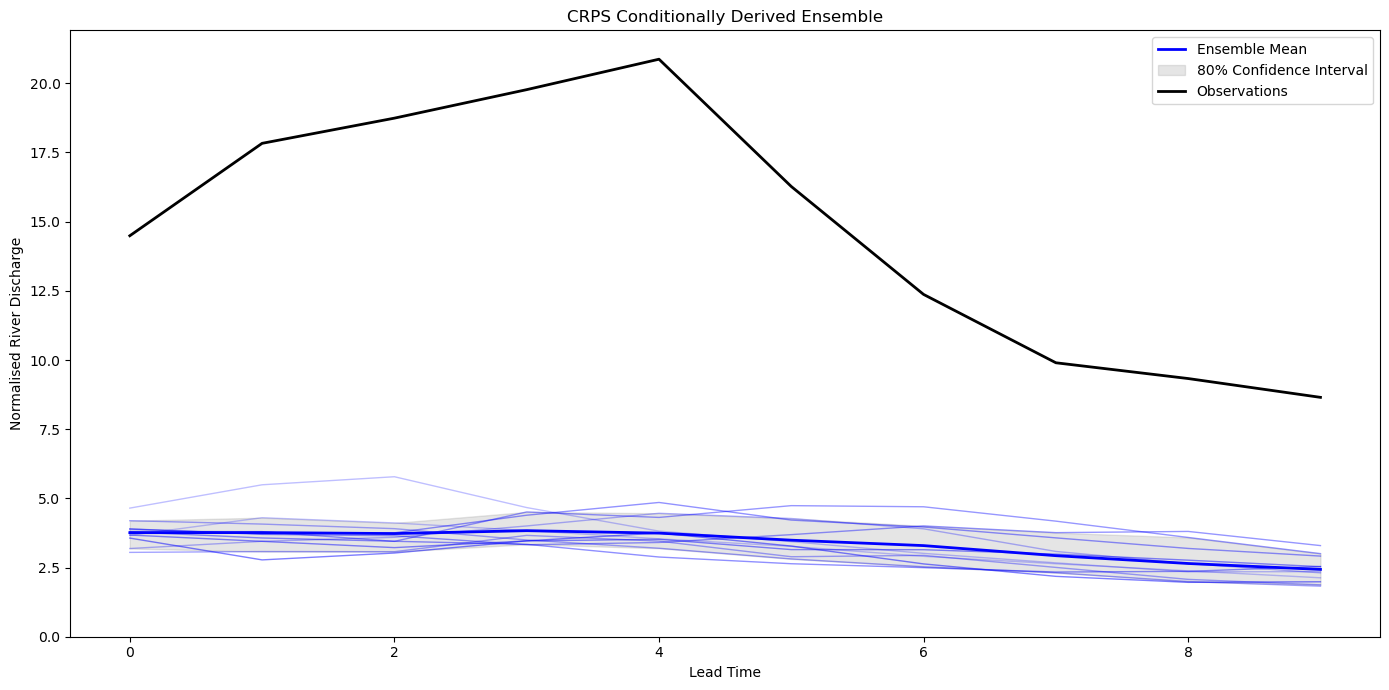

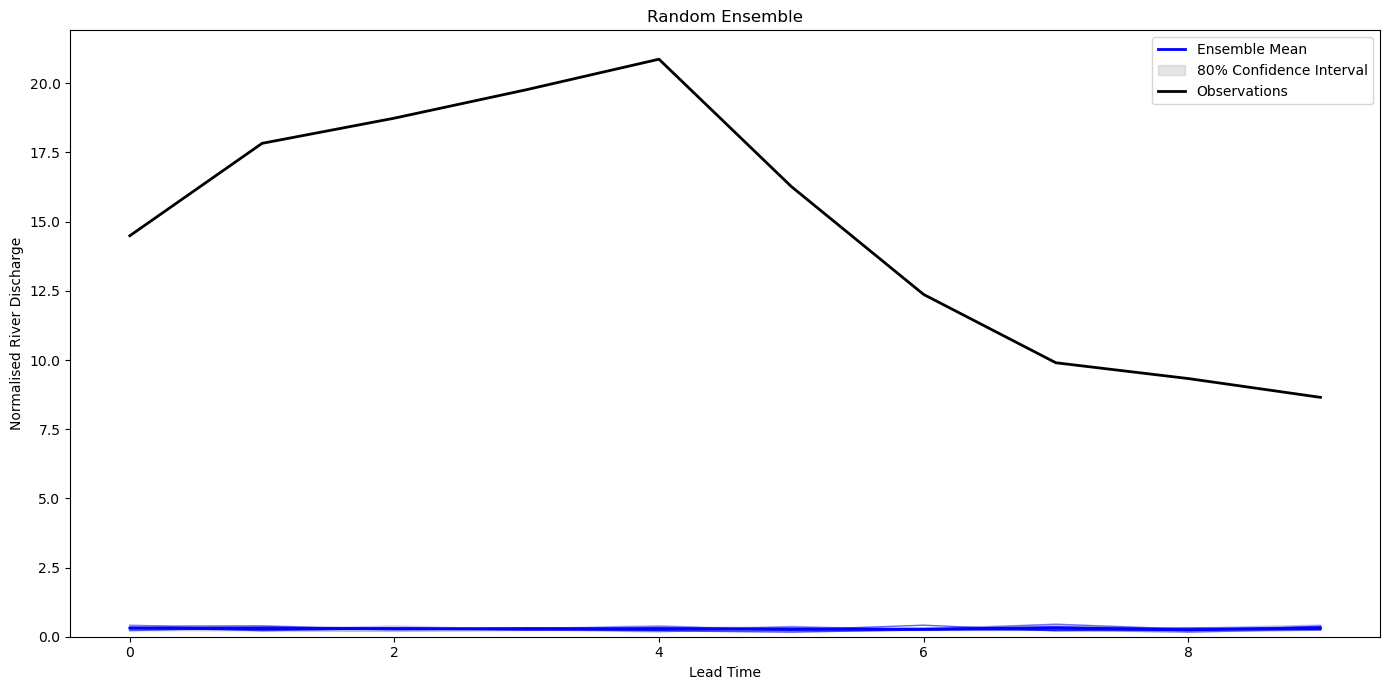

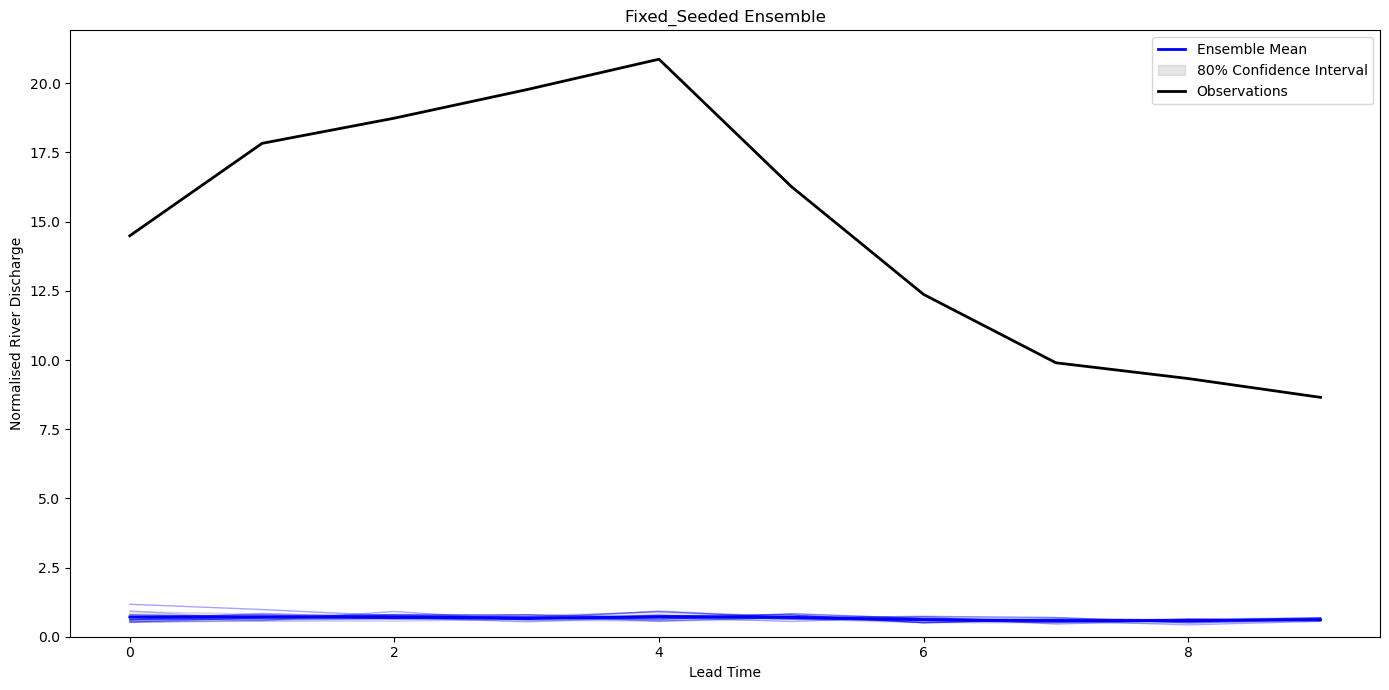

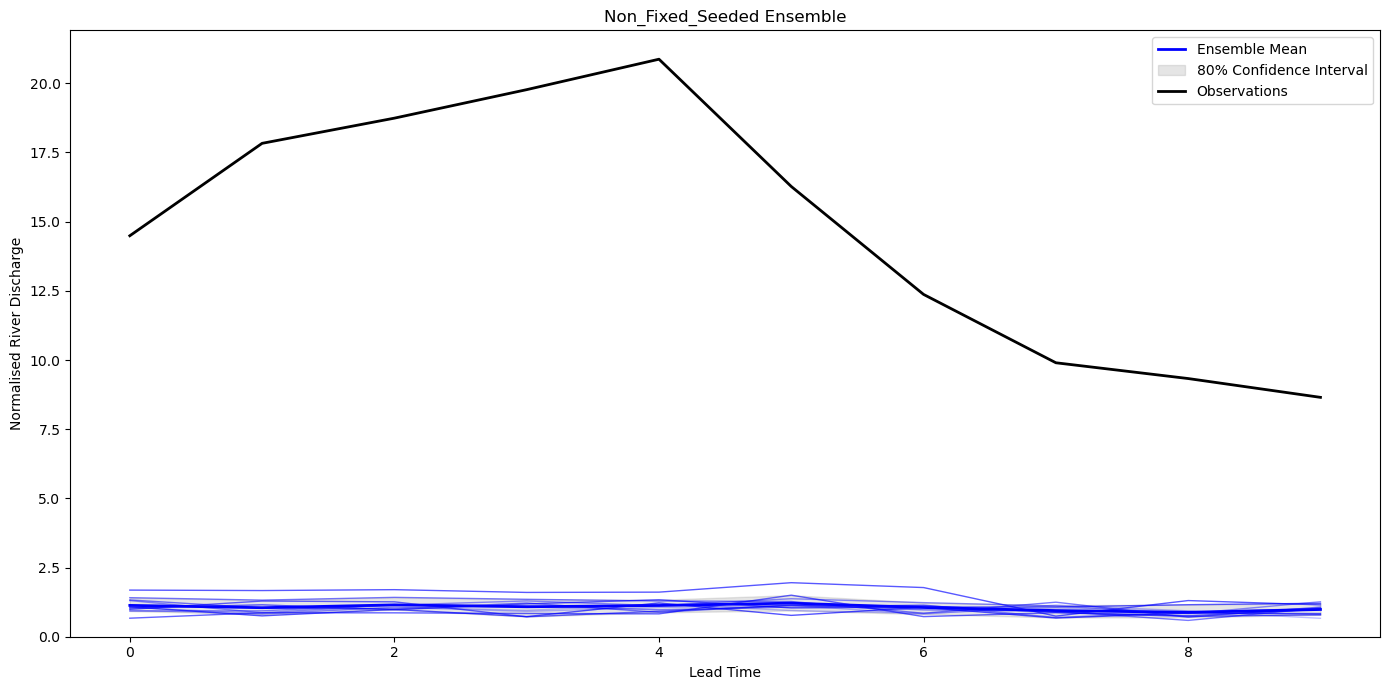

hysets_01010070 2018-05-05 00:00:00 19


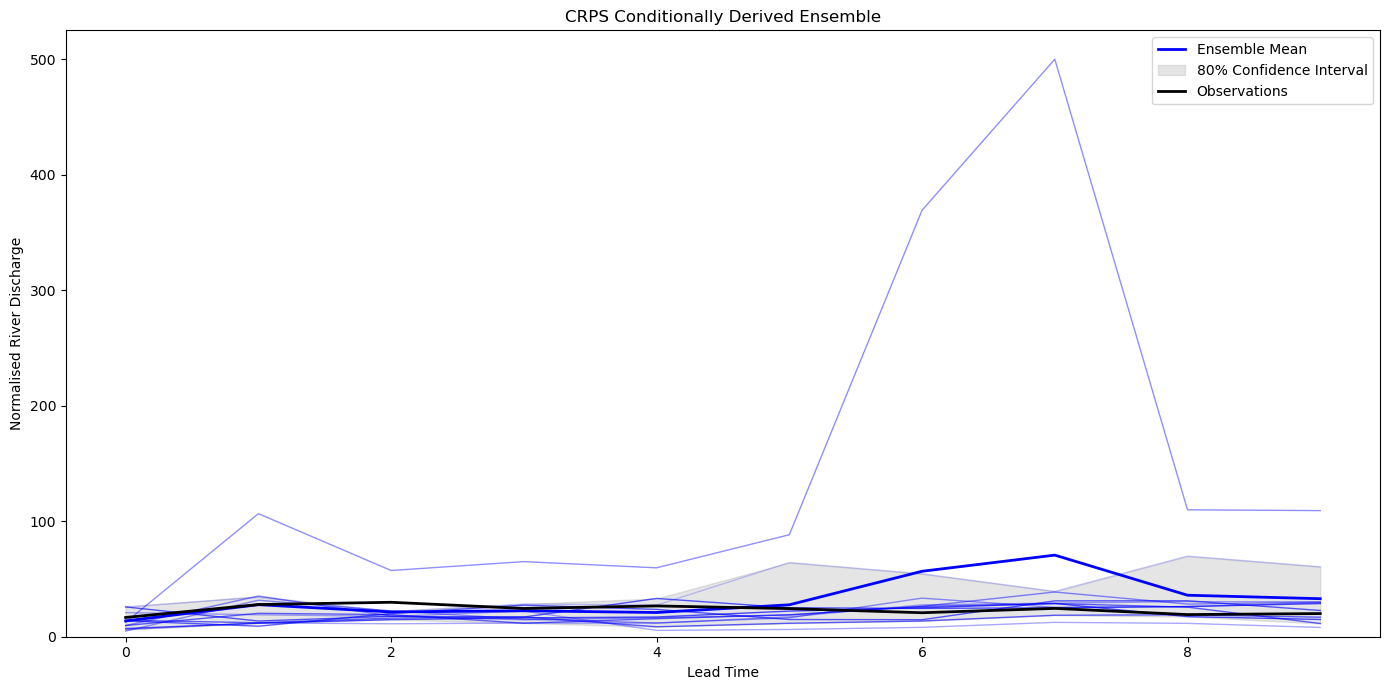

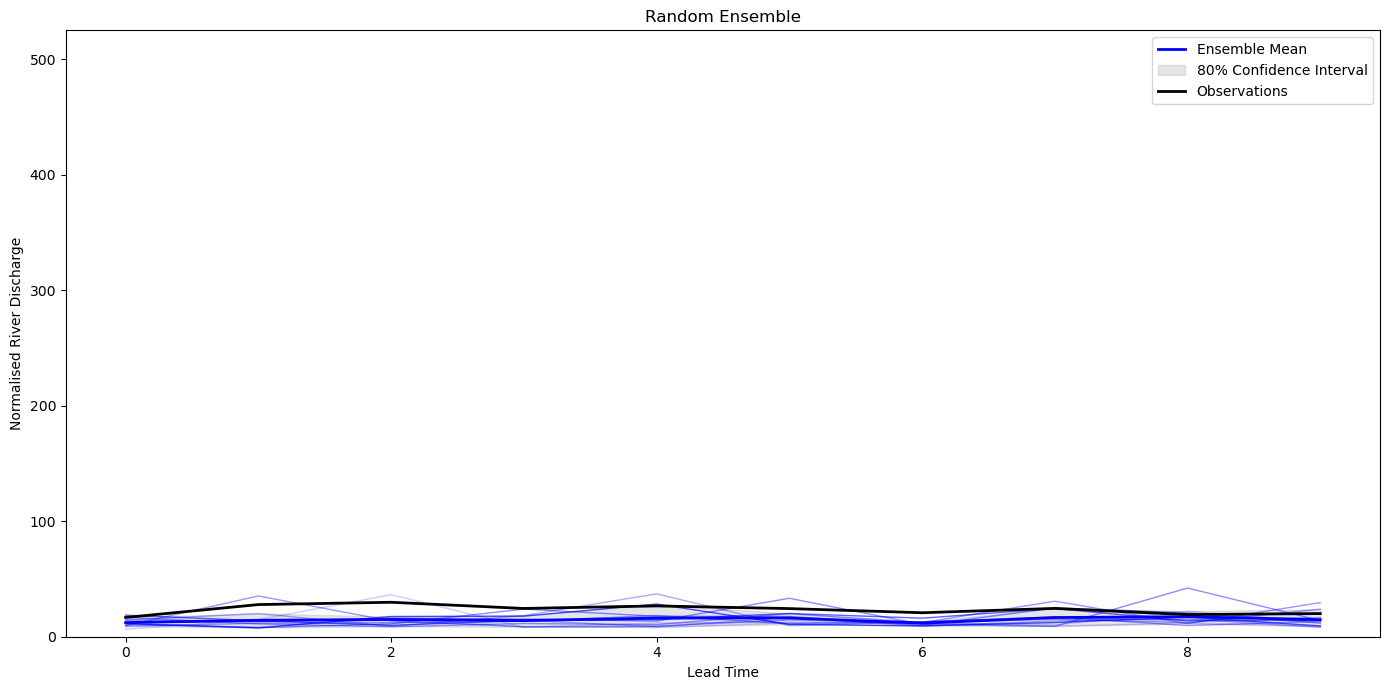

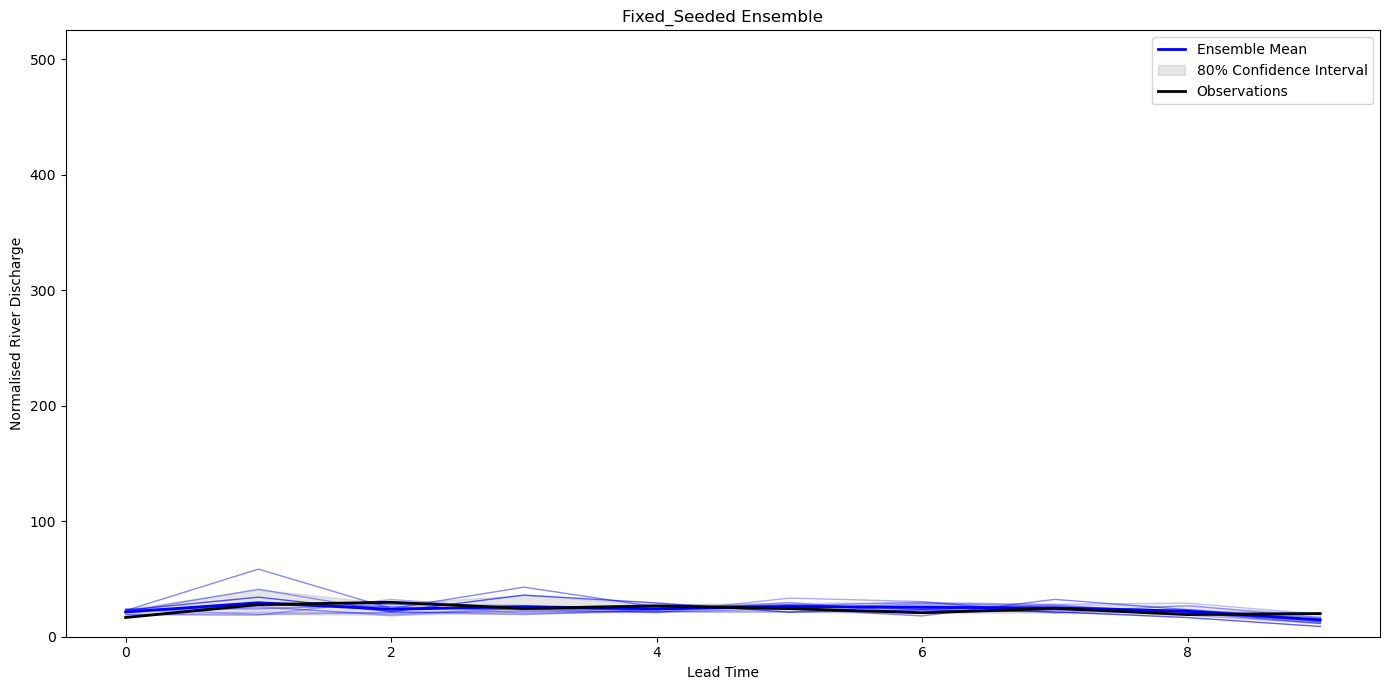

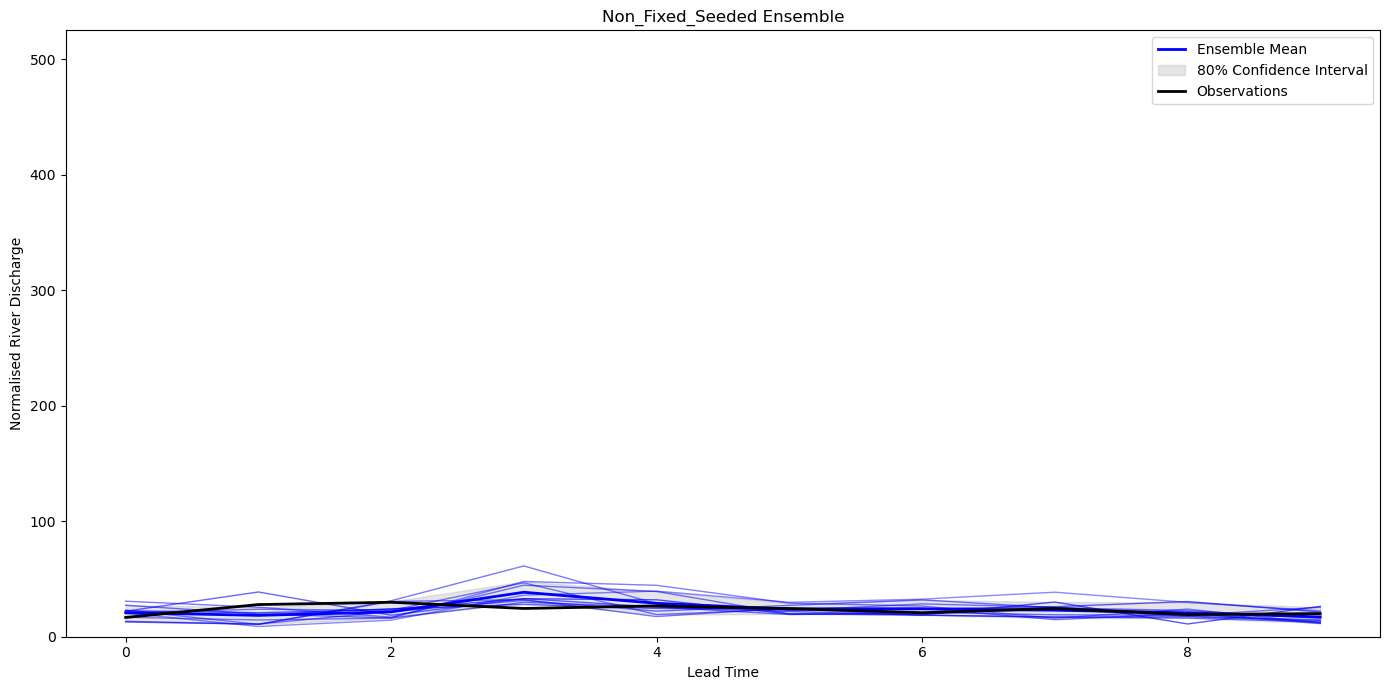

KeyboardInterrupt: 

In [29]:
for i, (Hist_X_Chunk_Torch, Fore_X_Chunk_Torch, Y_value, date_idx, basin_idx) in enumerate(Validation_Dataloader):
    
    if torch.isnan(Y_value).any():
        continue   
    
    if basin_idx not in basin_forecasts:
        basin_forecasts[basin_idx] = {"CRPS": [], "NLL": [], "Seeded": [], "Probabilistic": [], "Discharge": []}
            
    Fore_X_Chunk_Torch_Flagless = Fore_X_Chunk_Torch[:,:, 0:15]
    
    num_members = 11
    num_steps = Fore_X_Chunk_Torch.shape[1]

    # Get the members of the CRPS, CMAL, and Probabilistic models, unnormalise them and clip them to only predict positive discharge
    CRPS_ensemble_predictions =  get_ensemble_members_vectorized(Conditional_Model, Hist_X_Chunk_Torch, Fore_X_Chunk_Torch[:,:,0:15], num_members= num_members, keep_original = False)
    NLL_ensemble_predictions =  get_ensemble_members_vectorized(NLL_Conditional_Model, Hist_X_Chunk_Torch, Fore_X_Chunk_Torch[:,:,0:15], num_members= num_members, keep_original = False)
    Probabilistic_ensemble_predictions = get_nonbinary_ensemble_members(Probabilistic_Model, Hist_X_Chunk_Torch, Fore_X_Chunk_Torch[:,:,0:15], num_members= num_members, keep_original = False)
    
    CRPS_ensemble_predictions, NLL_ensemble_predictions, Probabilistic_ensemble_predictions = CRPS_ensemble_predictions.unsqueeze(1), NLL_ensemble_predictions.unsqueeze(1), Probabilistic_ensemble_predictions.unsqueeze(1)

    CRPS_ensemble_predictions[CRPS_ensemble_predictions < -0.26787253] = -0.2678724
    NLL_ensemble_predictions[NLL_ensemble_predictions < -0.26787253] = -0.2678724   
    Probabilistic_ensemble_predictions[Probabilistic_ensemble_predictions < -0.26787253] = -0.2678724   


    CRPS_ensemble_predictions, true_discharge = load_and_unnormalize(CRPS_ensemble_predictions, Y_value, scaler_path)
    NLL_ensemble_predictions, _ = load_and_unnormalize(NLL_ensemble_predictions, Y_value, scaler_path)
    Probabilistic_ensemble_predictions, _ = load_and_unnormalize(Probabilistic_ensemble_predictions, Y_value, scaler_path)

    true_discharge[true_discharge < 0] = 0

    # Do the same for the Fixed_Seeded and Non_Fixed_Seeded models
    Fixed_Seeded_ensemble_predictions = run_ensemble_predictions(Fixed_Noise_Seeded_Model, Hist_X_Chunk_Torch.to(torch.float32), Fore_X_Chunk_Torch_Flagless.to(torch.float32), num_members=num_members, noise_scale=1.0)
    Fixed_Seeded_ensemble_predictions[Fixed_Seeded_ensemble_predictions < -0.26787253] = -0.2678724   
    Fixed_Seeded_ensemble_predictions = Fixed_Seeded_ensemble_predictions.squeeze().unsqueeze(1)
    Fixed_Seeded_ensemble_predictions, _ = load_and_unnormalize(Fixed_Seeded_ensemble_predictions.detach(), Y_value)

    Non_Fixed_Seeded_ensemble_predictions = run_ensemble_predictions(Non_Fixed_Noise_Seeded_Model, Hist_X_Chunk_Torch.to(torch.float32), Fore_X_Chunk_Torch_Flagless.to(torch.float32), num_members=num_members, noise_scale=1.0)
    Non_Fixed_Seeded_ensemble_predictions[Non_Fixed_Seeded_ensemble_predictions < -0.26787253] = -0.2678724   
    Non_Fixed_Seeded_ensemble_predictions = Non_Fixed_Seeded_ensemble_predictions.squeeze().unsqueeze(1)
    Non_Fixed_Seeded_ensemble_predictions, _ = load_and_unnormalize(Non_Fixed_Seeded_ensemble_predictions.detach(), Y_value)
    
    
    # Convert everything to torch
    CRPS_ensemble_predictions, NLL_ensemble_predictions, Fixed_Seeded_ensemble_predictions, Non_Fixed_Seeded_ensemble_predictions, Probabilistic_ensemble_predictions, true_discharge = map(
        lambda x: torch.from_numpy(x).float(),
        [CRPS_ensemble_predictions, NLL_ensemble_predictions, Fixed_Seeded_ensemble_predictions, Non_Fixed_Seeded_ensemble_predictions, Probabilistic_ensemble_predictions, true_discharge]
    )
     

    
    # Store necessary information
    
    # CRPS

    model_preds = {
    "CRPS": CRPS_ensemble_predictions,
    "NLL": NLL_ensemble_predictions,
    "Fixed_Seeded": Fixed_Seeded_ensemble_predictions,
    "Non_Fixed_Seeded": Non_Fixed_Seeded_ensemble_predictions,
    "Probabilistic": Probabilistic_ensemble_predictions
    }

    process_ensemble_predictions(model_preds, true_discharge, basin_idx,
                           ensemble_summaries, crps_per_leadtime, variogram_scores, stored_forecasts,
                           NSE_scores, KGE_scores, basin_forecasts, variogram_p = 0.5)
    

    if Y_value[0][4]  > 0.85:
        print(basin_idx[0], date_idx[0], i)

        # plot_ensemble_predictions(CRPS_ensemble_predictions[:,0,:].squeeze().numpy(), true_discharge= true_discharge[0,:].squeeze().numpy(), title = 'CRPS Conditionally Derived Ensemble', plot_type='ensemble')
        # plot_ensemble_predictions(Probabilistic_ensemble_predictions[:,0,:].squeeze().numpy(), true_discharge= true_discharge[0,:].squeeze().numpy(), title = 'Random Ensemble', plot_type='ensemble')
        # # plot_ensemble_predictions(NLL_ensemble_predictions.squeeze().numpy(), true_discharge= true_discharge.squeeze().numpy(), title = 'NLL Conditionally Derived Ensemble', plot_type='both')
        # plot_ensemble_predictions(Fixed_Seeded_ensemble_predictions.squeeze().numpy(), true_discharge= true_discharge.squeeze().numpy(), title = 'Fixed_Seeded Ensemble', plot_type='ensemble')
        # plot_ensemble_predictions(Non_Fixed_Seeded_ensemble_predictions.squeeze().numpy(), true_discharge= true_discharge.squeeze().numpy(), title = 'Non_Fixed_Seeded Ensemble', plot_type='ensemble')

        max_val = max(
            CRPS_ensemble_predictions[:, :, :].max().item(), Probabilistic_ensemble_predictions[:, :, :].max().item(),
            Fixed_Seeded_ensemble_predictions.max().item(), Non_Fixed_Seeded_ensemble_predictions.max().item(),
            true_discharge[:, :].max().item()
        )
        
        # Add some padding so the top of the plot isn't touching the max
        ylims = (0, max_val * 1.05)
        
        # --- Plot with consistent y-axis limits ---
        plot_ensemble_predictions(CRPS_ensemble_predictions[:, 0, :].squeeze().numpy(), true_discharge=true_discharge[0, :].squeeze().numpy(),
            title='CRPS Conditionally Derived Ensemble', plot_type='ensemble', unnormalize=False, ylims=ylims)
    
        plot_ensemble_predictions(Probabilistic_ensemble_predictions[:, 0, :].squeeze().numpy(), true_discharge=true_discharge[0, :].squeeze().numpy(),
            title='Random Ensemble', plot_type='ensemble', unnormalize = False, ylims=ylims)
    
        plot_ensemble_predictions(Fixed_Seeded_ensemble_predictions.squeeze().numpy(), true_discharge=true_discharge.squeeze().numpy(),
            title='Fixed_Seeded Ensemble', plot_type='ensemble', unnormalize = False, ylims=ylims)
    
        plot_ensemble_predictions(Non_Fixed_Seeded_ensemble_predictions.squeeze().numpy(), true_discharge=true_discharge.squeeze().numpy(),
            title='Non_Fixed_Seeded Ensemble', plot_type='ensemble', unnormalize = False, ylims=ylims)
    
    
    # Stores dates
    dates.append(date_idx)
    basins.append(basin_idx)
    if i % 200 == 0:
        print(i)

    if i > 1e4:
        break

In [ ]:
mean_variogram_scores = {}
for model_name, scores in variogram_scores.items():
    if len(scores) > 0:
        # Convert tensors to numpy if needed
        if isinstance(scores[0], torch.Tensor):
            scores_np = [s.item() if s.numel() == 1 else s.cpu().numpy() for s in scores]
        else:
            scores_np = scores
        
        mean_variogram_scores[model_name] = {
            'Mean': np.mean(scores_np),
            'Std': np.std(scores_np),
            'Min': np.min(scores_np),
            'Max': np.max(scores_np),
            'N_Inits': len(scores_np)
        }

# Create DataFrame
df = pd.DataFrame(mean_variogram_scores).T

# Sort by mean score (lower is better)
df = df.sort_values('Mean')

df